# Morphological analysis with FSTs

The following is a brief and basic tutorial on how to construct a morphological analyzer for a language using finite-state techniques. A small toy grammar of English noun and verb inflection is built step-by-step to illustrate overall design issues. While the grammar is small, much larger grammars can be built using the same design principles. Basic familiarity with regular expressions and __PyFoma__ is assumed.

## Definition

Since a "morphological analyzer" could mean any number of things, let's first settle on a task description and define what the morphological analyzer is supposed to accomplish. In this implementation, a morphological analyzer is taken to be a black box (as in Fig. 1), which happens to be implemented as a finite-state transducer, that translates word forms (such as `runs`) into a string that represents its morphological makeup, such as `run[V][3p][Sg]`: a verb in the third person singular present tense.

![Morphological analyzer example](./images/analyzerexample1.png)

Naturally, if the word form is ambiguous (as `runs` is), the job of the analyzer is to output all tag sequences consistent with the grammar and the input word. In the above example, the transducer should perhaps also output `run[N][Pl]`, or some similar sequence to convey the possibility of a noun reading of `runs`. Since finite-state transducers are inherently bidirectional devices, i.e. we can run a transducer in the inverse direction as well as the forward direction, the same FST, once we've built it, can serve *both as a generator and an analyzer*. The standard practice is to build morphological transducers so that the input (or domain) side is the analysis side, and the output (or range) side contains the concrete word forms.

In real life, morphological analyzers tend to provide much more detailed information than this. Figure 2 shows a more elaborate analyzer's output for Basque with the input work `maiatzaren`, together with an illustration about how a feature matrix can be recovered from the string output of the analyzer.


![Morphological analyzer example](./images/maiatzaren.png)

The goal is then is build a finite-state transducer that accomplishes this string-to-string mapping of analyses to surface forms and vice versa.


# Design

The construction of the final transducer will be broken down into two large components:

* A lexicon/morphotactics part
* A phonological/morphophonological/orthographic part

## The Lexicon

The first component, which we call the lexicon component, will be a transducer that:

* Accepts as input only the valid stems/lemmas of the language, followed by only a legal sequence of tags.

* Produces as output from these, an intermediate form, where the tags are replaced by the morphemes that they correspond to.

* May produce additional symbols in the output, such as special symbols that serve to mark the presence of morpheme boundaries.

* For example, in the analyzer about to be constructed, the lexicon component FST will perform the following mappings:

```
c a t [N] [Pl]      w a t c h [N] [Pl]     w a t c h [V] [3P] [Sg]   (input side)
c a t +   s         w a t c h +   s        w a t c h +   s           (output side)
```

There are two things to note here. The first is that we are using the symbol `+` to mark a morpheme boundary. The second is that while each letter in the stem is represented by its own symbol (`w`,`a`,`t`,`c`,`h`, etc.), each complete tag is one separate symbol, a multicharacter symbol (`[N]`, `[Pl]`, etc.) The spaces in the above show the symbol boundaries to illustrate this.

The part that accomplishes this, the lexicon transducer, will be written as a __right-linear grammar__ (using the `rlg` method of the `FST` class). While it is possible to construct the lexicon transducer through regular expressions in __PyFoma__, the `rlg` is more suited for lexicon construction and expressing morphotactics in a legible fashion.


## Alternation rules

The role of the alternation rules is to modify the output of the lexicon transducer according to orthographic, phonological, and morphophonological rules and conventions. So far, for example, we've assumed that English nouns can be pluralized by concatenating the morpheme `s` with the stem (`cat` → `cats`). However, some nouns, those where the stem ends in a sibilant, have the allomorph `es` (`watch` → `watches`). A way to describe the process of forming correct nouns is to consistently represent the plural as the morpheme `s` as we have, and then subject these word forms to alternation rules that insert an `e` in the right place only if the stem ends in a sibilant. This, among others, is the task of the alternation rules component: to produce the valid surface forms from the intermediate forms output by the lexicon transducer.

Since alternation rule FSTs that are conditioned by their environment are very difficult to construct by hand, we use the rewrite rules formalism in __PyFoma__ (`$^rewrite()`) to compile the necessary rules into FSTs.

After the necessary replacement rules have been built, we compose together the lexicon FST and these various FSTs that encode such alternations as `e`-insertions, producing one large transducer that acts like a cascade - a single transducer that has the same effect as would providing an input word to the lexicon transducer, take its output and feed it into the first rule transducer, take it's output, then feed it into the next rule transducer, and so on.

This is accomplished by the regular expression composition operator (`@`). Suppose we have the lexicon transducer in an FST we've named `Lexicon`, and the various alternation rules as FSTs named `rule_1`, ..., `rule_n` (in reality we might want to use more perspicuous names). Now, we can issue the regular expression:

```python
FST.re("$Lexicon @ $rule_1 @ ... @ $rule_n")
```

and produce a single transducer that is the composite of the different rule transducers and the lexicon transducer.

![Composite analyzer / generator](./images/compositeanalyzergenerator.png)

This is indeed one of the main reasons to use finite-state transducers for morphological analysis: the fact that we can describe the word-formation rules in the direction of generation, but in fact use the final FST in the other direction. It would be trivial to write little programs (in one's programming language of choice) to perform the lexicon mapping and the alternation rules mappings, each little program's output being fed as the next program's input, and so provide a model for *generation*. But with such a program, we generally have no way to perform analysis, and would need to implement that separately. The fact that we can calculate the composition of each individual transducer, is what makes this possible.

Although we write the grammar in the direction of generation, we at the same time produce an analyzer, or parser. This is because the final product is represented as one single transducer and transducers operate just as easily in the inverse direction. All the software has to do when parsing (applying the transducer in the inverse direction), is to follow the output labels on each transition that correspond to the word to parsed, and output the matching input labels.

## The lexicon

As mentioned, the lexicon script that will be a transducer that maps analysis forms to intermediate forms will be written in the `rlg`-formalism.

## The facts to be modeled

Before moving further, let's narrow down the details we want to capture in our analyzer.

We'll want to include the following noun/verb features into the grammar.

* Nouns: singular (cat) vs. plural (cats)
* Verbs: infinitive (watch), 3rd person singular (watches), past tense (watched), past participle (watched), and present participle (watching)


### Tags

We'll also want to use the following tags for marking the above grammatical information.

* `[N]` for nouns
* `[V]` for verbs
* `[3P]` for third person
* `[Sg]` for singular forms
* `[Pl]` for plural forms
* `[Past]` for past tense
* `[Past] [Part]` for past participle
* `[Pres] [Part]` for present participle

## The right-linear grammar

A [right-linear grammar](https://en.wikipedia.org/wiki/Linear_grammar) is a formalism for generating strings using a grammar of rewrite rules (not to be confused with the rewrite rules we'll later use for morphophonology). Each rule consists of (1) exactly one non-terminal symbol on the left hand side (of the arrow), and the right-hand sides consist of (2) zero or more terminal symbols followed by (3) at most one non-terminal symbol.

Below is a simple right-linear grammar that generates the strings `{cat, dog, cats, dogs, walk, buy, sell, buying, selling}`.

![Right-linear grammar](./images/rlg1.png)

All right-linear grammars are expressible as automata and vice versa, and the purpose of the compilation is to convert our right-linear grammar to an automaton (or transducer - more on that below). For example, this automaton models exactly the same set of words as the grammar above generates:

![Automaton from right-linear grammar](./images/rlg2.png)

## Right-linear grammars with input and output

Since we not only want to generate the legal configuration of morphemes, but also to map morphemes' tags on the input side of a transduction to the actual morphemes, the right-linear grammar formalism allows for specification of different inputs and outputs.

Here is our grammar written in formal notation.

```
S → &#x03f5; Noun | &#x03f5; Verb
Noun → cat NInfl | city NInfl | box NInfl | panic NInfl | try NInfl | watch NInfl
Verb → beg VInfl | box VInfl | fake VInfl | panic VInfl | try VINfl | watch VInfl
NInfl → ([N] [Sg]):&#x03f5; # | ([N] [Pl]):+s #
VInfl → ([V]):&#x03f5; # | ([V] [3P] [Sg]):+s # | ([V] [Past]):+ed # | ([V] [Past] [Part]):+ed # |
        ([V] [Pres] [Part]):+ing # 


```

Note the `NInfl` and `VInfl` nonterminals which expand into a sequence of tags on the input side, corresponding to morphemes (such as `+ing` or `+ed` or `+s`) on the output side. A special nonterminal `#` denotes end-of-generation and must always be present when a derivation ends.

This translates into Python as follows:

In [1]:
from pyfoma import FST
Grammar = {}
Grammar["S"] = [("", "Noun"), ("", "Verb")] # S -> &#x03f5; Noun|&#x03f5; Verb
Grammar["Noun"] = [("cat", "NInfl"), ("city", "NInfl"), ("box", "NInfl"), \
                   ("panic", "NInfl"),("try", "NInfl"),("watch", "NInfl")]

Grammar["Verb"] = [("beg", "VInfl"), ("box", "VInfl"), ("fake", "VInfl"), \
                   ("panic", "VInfl"),("try", "VInfl"),("watch", "VInfl")]

Grammar["NInfl"] = [(("'[N]''[Sg]'", ""), "#"), (("'[N]''[Pl]'", "+s"), "#")]

Grammar["VInfl"] = [(("'[V]'", ""), "#"), (("'[V]''[3P]''[Sg]'", "+s"), "#"), \
                    (("'[V]''[Past]'", "+ed"), "#"), (("'[V]''[Past]''[Part]'", "+ed"), "#"), \
                    (("'[V]''[Pres]''[Part]'", "+ing"), "#")]

Here, all the grammar rules are put into a dictionary, which is arbitrarily called `Grammar`. Each key in the dictionary is a left-hand-side of a rule, and the corresponding value is a tuple/iterable of possible right-hand-sides. If the input is different from the output (as on lines 9-13) the right-hand side nonterminals are represented as 2-tuples like `("'[N]' '[Sg]'", "")`. The tag symbols `[N]` `[V]` etc. are quoted so that they become single atomic symbols in the resulting automaton (and not a sequence `[` `N` `]` or `[` `V` `]`). This is common practice when designing morphological transducers - tags are multicharacter symbols while actual word forms are concatenations of alphabetic symbols, e.g. `c` `a` `t`.

Now that we have the grammar's dictionary structure in place, we can compile it into a non-deterministic transducer with the `FST` method `rlg()`. The method takes two arguments: the dictionary and the designated start symbol (`S` in our case).

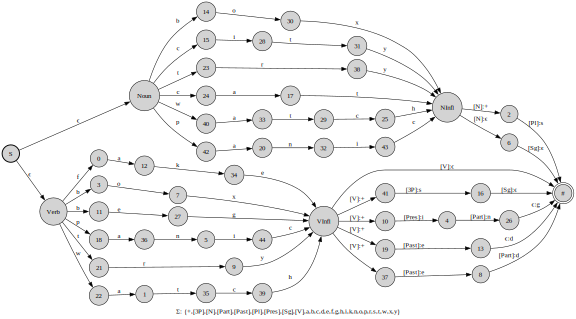

In [2]:
Lexicon = FST.rlg(Grammar, "S")
Lexicon.view()

You can observe that all the nonterminals in the grammar (`S`, `Verb`, `Noun`, `VInfl`, `NInfl` and `#`) have their own states in the corresponding transducer. This is meant for debugging purposes so that the logic of the lexicon is easier to follow. For actual subsequent use, we need to (1) remove the epsilons, (2) determinize, and (3) minimize the transducer.

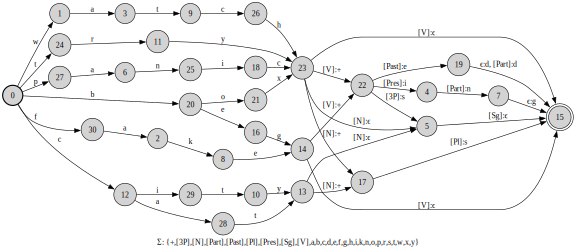

In [3]:
Lexicon = Lexicon.epsilon_remove().determinize().minimize()
Lexicon.view()

We can now examine this transducer to make sure the input forms and corresponding intermediate forms are correct before moving to the rewrite rules component. The `Paradigm` function allows us to print out the input-output pairs of a transducer, possibly filtered with some regular expressions. For example, to just print out the pairs where the input side begins with the string `try` we do:

In [4]:
from pyfoma import Paradigm
print(Paradigm(Lexicon, "try.*"))

try  [N][Pl]          try+s    
try  [N][Sg]          try      
try  [V]              try      
try  [V][3P][Sg]      try+s    
try  [V][Past]        try+ed   
try  [V][Past][Part]  try+ed   
try  [V][Pres][Part]  try+ing  



To print out *all* the input-output pairs, we just set the filter regex to `.*`:

In [5]:
print(Paradigm(Lexicon, ".*"))

beg    [V]              beg        
beg    [V][3P][Sg]      beg+s      
beg    [V][Past]        beg+ed     
beg    [V][Past][Part]  beg+ed     
beg    [V][Pres][Part]  beg+ing    
box    [N][Pl]          box+s      
box    [N][Sg]          box        
box    [V]              box        
box    [V][3P][Sg]      box+s      
box    [V][Past]        box+ed     
box    [V][Past][Part]  box+ed     
box    [V][Pres][Part]  box+ing    
cat    [N][Pl]          cat+s      
cat    [N][Sg]          cat        
city   [N][Pl]          city+s     
city   [N][Sg]          city       
fake   [V]              fake       
fake   [V][3P][Sg]      fake+s     
fake   [V][Past]        fake+ed    
fake   [V][Past][Part]  fake+ed    
fake   [V][Pres][Part]  fake+ing   
panic  [N][Pl]          panic+s    
panic  [N][Sg]          panic      
panic  [V]              panic      
panic  [V][3P][Sg]      panic+s    
panic  [V][Past]        panic+ed   
panic  [V][Past][Part]  panic+ed   
panic  [V][Pres][Part]  pani

## The alternation rules component
 
 Having accomplished the first part of the grammar construction, we now turn to the alternation rules component. The idea is to construct a set of ordered rule transducers that modify the intermediate forms output by the lexicon component. At the very least we will need to remove the `+`-symbol which is used to separate morpheme boundaries before we produce valid surface forms. This will in fact be the last rule transducer in the cascade. Before that rule applies, however, there are several rules that are needed for orthographic and phonological adjustment.

### The facts to be modeled

#### e-deletion

Stems that end in a silent `e` drop the `e` with certain suffixes (`ing` and `ed` in our case). For example, `fake → faking`. This can be captured by:

```python
FST.re("$^rewrite(e:'' / _ \+ [ei])")
```

In other words, applying the rule to the output of the lexicon component, we get changes like:

```
f a k e [V] [Pres] [Part]     (lexicon input)
f a k e +  i          n g     (lexicon output)
f a k   +  i          n g     (after e-deletion)
```

In order to accommodate re-use of the rules, we store each rule in a dictionary `fsts` where the key is the name of the rule and the value the transducer. We'll keep building up the dictionary as we build and test each rule in turn, starting with the `e-deletion` rule.

In [6]:
fsts = {} # Empty dictionary for rules
fsts['edelete'] = FST.re("$^rewrite(e:'' / _ \+ [ei])")

We can now test the rule independently with the `generate`-method, passing a single input word through it:

In [7]:
list(fsts['edelete'].generate("fake+ing"))

['fak+ing']

(Note: the generate function returns a generator which yields all the possible outputs, as some transducers can produce infinitely many outputs. So in order to examine the outputs, we need to convert to a list.)

#### y-replacement

The y-replacement rule which acts in constructions such as `try → tries` and `try → tried` is perhaps best broken into two parts. Consider the corresponding input-intermediate form pairings:

```
    (1)                   (2)
t r y   [V][3P][Sg]    t r y [V] [Past] [Part]    (lex in)
t r y   +  s           t r y +  e            d    (lex out)
t r i e +  s           t r i +  e            d    (desired rule output)

```

Now, in the event that the verb ends in `y` and is followed by morpheme boundary and `s` (1), we want to change the `y` into `i e`, whereas case (2) requires only changing the `y` into `i`. We can accomplish this by having two separate rules combined with composition (`@`). We also take a look at the transducer and test two words.

In [8]:
fsts['yreplace'] = FST.re("$^rewrite(y:(ie) / _ \+ s) @ $^rewrite(y:i / _ \+ ed)")
fsts['yreplace'].view()
print(list(fsts['yreplace'].generate("try+s")))
print(list(fsts['yreplace'].generate("try+ed")))

['trie+s']
['tri+ed']


#### e-insertion

We also have an `e`-insertion rule: whenever a stem ends in a sibilant and is followed by the plural morpheme s (`watch → watches`). Sibilants can be defined orthographically by `s`, `z`, `x`, `c h`, and `s h` (corresponding to the sounds /s/, /z/, /ks/, /tʃ/ and /ʃ/). The rule then looks like:

```
FST.re("$^rewrite('':e / (s|z|x|ch|sh) \+ _ s)")
```

Note that the above rule will work for the words we've defined in our lexicon. However, the sibilant representation in English orthography is not entirely consistent. For example, a word such as `monarch` would trigger the rule and incorrectly yield *`monarches` in the plural. One way to handle such exceptions is to rewrite any `c h` sequence in the lexicon component pronounced as /k/ with some symbol that will not trigger `e`-insertion (say `K`), which is then rewritten back to `c h` after all the rules have applied, thereby bypassing the rule.

In [9]:
fsts['einsert'] = FST.re("$^rewrite('':e / (s|z|x|ch|sh) \+ _ s)")
list(fsts['einsert'].generate("watch+s"))

['watch+es']

#### k-insertion

Verbs that end in a `c` (corresponding to a phonological `k`), add a `k` before the morpheme boundary if followed by an affix beginning with a vowel. For example `panic → panicking, panicked`. We can identify quite accurately when the `k` needs to be inserted as it is preceded by a vowel in those cases (as opposed to, say the verb construction `sync → syncing`). The rule can then be captured by:

```python
FST.re("$^rewrite('':k / $C $V c _ \+ $V")
```

Of course, this rule relies on us having defined `$V` and `$C` as our set of vowel and consonant symbols, respectively.

In [10]:
fsts['V'] = FST.re("[aeiou]")         # Vowels
fsts['C'] = FST.re("[a-z] - [aeiou]") # Consonants; note set subtraction

fsts['kinsert'] = FST.re("$^rewrite('':k / $C $V c _ \+ $V)", fsts) # Note passing of fsts as arg 2
list(fsts['kinsert'].generate("panic+ed"))

['panick+ed']

Note line 4 where we pass the `fsts` dictionary as a second argument to the regex compiler - this is how the compiler can access the definitions of `$C` and `$V` during compilation.

#### Consonant doubling (gemination)

Consonant doubling is really the same phenomenon as the k-insertion. We double final consonants in the stem in certain environments: `beg → begging`, `run → running`, etc. Our lexicon contains only one such word (beg), so we can make do with a simple rule:

```python
FST.re("$^rewrite(g:(gg) / $C $V _ \+ $V)")
```

For a more thorough treatment, we'd also need to add rules for the other consonants. Although, this again is a phenomenon that is not perfectly capturable without additional knowledge as to the pronunciation of the word. The consonant doubling only happens when the final syllable of the stem is stressed. Compare `commit → committing` and `edit → editing`. The latter word fulfills the structural requirements of the rewrite rule (a `C V`-sequence before the consonant to be doubled), yet the gemination isn't permitted. To handle such idiosyncracies in English, one would have to add information about stress in the lexicon. Perhaps `commit` would be represented as `com'mit` and `edit` as `'edit` which would reveal whether the stem-final syllable is stressed. The stress information could then be used in the gemination rule, after which the stress symbols could be deleted.

In [11]:
fsts['geminate'] = FST.re("$^rewrite(g:(gg) / $C $V _ \+ $V)", fsts)
list(fsts['geminate'].generate("beg+ing"))

['begg+ing']

#### Auxiliary symbol removal

Naturally, as the last rule, we need to remove the auxiliary `+`, whose presence has been necessary for the correct definition of the alternation rules. The last rule removes these, after which we've produced valid surface forms:

```python
FST.re("$^rewrite(\+:'')")
```

In [12]:
fsts['cleanup'] = FST.re("$^rewrite(\+:'')")
list(fsts['cleanup'].generate("begg+ing"))

['begging']

## Compiling the grammar

The final step is to compose together our `Lexicon` transducer with all the relevant rules, the `cleanup`-rule being last in the composition.

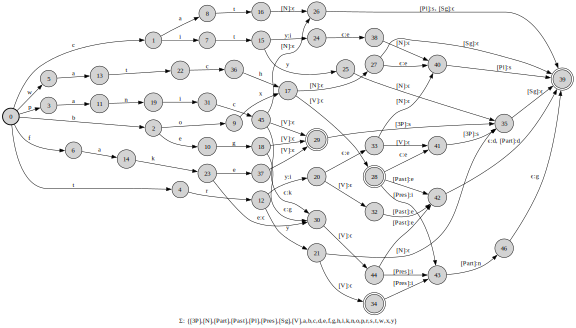

In [13]:
fsts['Lexicon'] = Lexicon  # Add lexicon to the dictionary so the compiler can find $Lexicon
English = FST.re("$Lexicon @ $edelete @ $einsert @ $yreplace @ $kinsert @ $geminate @ $cleanup", fsts)
English.view()

We can now look at all the input-output pairs generated by the grammar. Nouns first, then verbs:

In [14]:
print(Paradigm(English, ".*'[N]'.*"))

box    [N][Pl]  boxes    
box    [N][Sg]  box      
cat    [N][Pl]  cats     
cat    [N][Sg]  cat      
city   [N][Pl]  cities   
city   [N][Sg]  city     
panic  [N][Pl]  panics   
panic  [N][Sg]  panic    
try    [N][Pl]  tries    
try    [N][Sg]  try      
watch  [N][Pl]  watches  
watch  [N][Sg]  watch    



In [15]:
print(Paradigm(English, ".*'[V]'.*"))

beg    [V]              beg        
beg    [V][3P][Sg]      begs       
beg    [V][Past]        begged     
beg    [V][Past][Part]  begged     
beg    [V][Pres][Part]  begging    
box    [V]              box        
box    [V][3P][Sg]      boxes      
box    [V][Past]        boxed      
box    [V][Past][Part]  boxed      
box    [V][Pres][Part]  boxing     
fake   [V]              fake       
fake   [V][3P][Sg]      fakes      
fake   [V][Past]        faked      
fake   [V][Past][Part]  faked      
fake   [V][Pres][Part]  faking     
panic  [V]              panic      
panic  [V][3P][Sg]      panics     
panic  [V][Past]        panicked   
panic  [V][Past][Part]  panicked   
panic  [V][Pres][Part]  panicking  
try    [V]              try        
try    [V][3P][Sg]      tries      
try    [V][Past]        tried      
try    [V][Past][Part]  tried      
try    [V][Pres][Part]  trying     
watch  [V]              watch      
watch  [V][3P][Sg]      watches    
watch  [V][Past]        watc

## Some optimizations

In the Lexicon component, we performed a lot of repetitive work for each noun and verb when defining the right-linear-grammar. In a more realistic scenario, we would have a separate list (or a file) of noun stems and verb stems. The right-linear grammar could then be built as a *list comprehension* for compactness, as is done here on lines 7 and 8:

In [16]:
nouns = ['box,', 'cat', 'city', 'panic', 'try', 'watch']
verbs = ['beg', 'box', 'fake', 'panic', 'try', 'watch']
Grammar = {}
Grammar["S"] = [("", "Noun"), ("", "Verb")] # S -> &#x03f5; Noun|&#x03f5; Verb

Grammar["Noun"] = [(n, "NInfl") for n in nouns]
Grammar["Verb"] = [(v, "VInfl") for v in verbs]

Grammar["NInfl"] = [(("'[N]''[Sg]'", ""), "#"), (("'[N]''[Pl]'", "+s"), "#")]

Grammar["VInfl"] = [(("'[V]'", ""), "#"), (("'[V]''[3P]''[Sg]'", "+s"), "#"), \
                    (("'[V]''[Past]'", "+ed"), "#"), (("'[V]''[Past]''[Part]'", "+ed"), "#"), \
                    (("'[V]''[Pres]''[Part]'", "+ing"), "#")]

## Irregular forms

In the grammar above we only included regular nouns and verbs. For example, we had the regular verb `fake` that has the past tense `faked`. But what if we wanted to include `make`, whose past tense is `made`? We can't directly add `make` to our `Lexicon`, because then the system will inflect it as `maked`. The standard solution is to add *all* regular stems to a core grammar - we could add a lot of them to the above grammar and produce correct behavior - and then to perform a separate special treatment of irregulars. For the verb `make`, this could mean adding a couple of extra entries to the right-linear grammar, as follows:

In [17]:
Grammar["Verb"] += [(("make '[V]'", "make"), "#"),\
                    (("make '[V]' '[Pres]' '[Part]'", "making"), "#"), \
                    (("make '[V]' '[Past]'", "made"), "#"), \
                    (("make '[V]' '[3P]' '[Sg]'", "makes"), "#"), \
                    (("make '[V]' '[Past]' '[Part]'", "made"), "#")]

In effect, we simply list all the irregular forms, bypassing the `VInfl`-rule for all of them, and directly generate the end-of-word symbol `#`.  We can now recompile the grammar and check that the added forms of `make` are correct and compare with the regular verb `fake`.

In [18]:
fsts['Lexicon'] = FST.rlg(Grammar, "S").epsilon_remove().determinize().minimize()
English = FST.re("$Lexicon @ $edelete @ $einsert @ $yreplace @ $kinsert @ $geminate @ $cleanup", fsts)
print(Paradigm(English, ".ake'[V]'.*"))

fake  [V]              fake    
fake  [V][3P][Sg]      fakes   
fake  [V][Past]        faked   
fake  [V][Past][Part]  faked   
fake  [V][Pres][Part]  faking  
make  [V]              make    
make  [V][3P][Sg]      makes   
make  [V][Past]        made    
make  [V][Past][Part]  made    
make  [V][Pres][Part]  making  



# Summary

We now have an analyzer and generator for some basic English inflection, which we can use through the `analyze()/generate()` methods:

In [19]:
list(English.generate("panic[V][Past][Part]"))

['panicked']

In [20]:
list(English.analyze("watches"))

['watch[V][3P][Sg]', 'watch[N][Pl]']

This construction of morphological FSTs in two parts, as a lexicon FST composed with a set of rule FSTs is the standard method.  For more advanced topics, such as different ways of including irregular forms, modeling circumfixes and reduplication, see the advanced tutorial.

# Complete code

Below is the above code in one chunk.

In [21]:
from pyfoma import FST

# Right-linear grammar for lexicon

Grammar = {}
Grammar["S"] = [("", "Noun"), ("", "Verb")] # S -> &#x03f5; Noun|&#x03f5; Verb
Grammar["Noun"] = [("cat", "NInfl"), ("city", "NInfl"), ("box", "NInfl"), \
                   ("panic", "NInfl"),("try", "NInfl"),("watch", "NInfl")]

Grammar["Verb"] = [("beg", "VInfl"), ("box", "VInfl"), ("fake", "VInfl"), \
                   ("panic", "VInfl"),("try", "VInfl"),("watch", "VInfl")]

Grammar["NInfl"] = [(("'[N]''[Sg]'", ""), "#"), (("'[N]''[Pl]'", "+s"), "#")]

Grammar["VInfl"] = [(("'[V]'", ""), "#"), (("'[V]''[3P]''[Sg]'", "+s"), "#"), \
                    (("'[V]''[Past]'", "+ed"), "#"), (("'[V]''[Past]''[Part]'", "+ed"), "#"), \
                    (("'[V]''[Pres]''[Part]'", "+ing"), "#")]

fsts = {} # Store all transducers in this dictionary

fsts['Lexicon'] = FST.rlg(Grammar, "S").epsilon_remove().determinize().minimize()

# Definitions
fsts['V'] = FST.re("[aeiou]")         # Vowels
fsts['C'] = FST.re("[a-z] - [aeiou]") # Consonants

# Rewrite Rules
fsts['edelete'] = FST.re("$^rewrite(e:'' / _ \+ [ei])") # make+ing > mak+ing
fsts['yreplace'] = FST.re("$^rewrite(y:(ie) / _ \+ s) @ $^rewrite(y:i / _ \+ ed)") # try+s > trie+s
fsts['einsert'] = FST.re("$^rewrite('':e / (s|z|x|ch|sh) \+ _ s)")   # watch+s > watch+es
fsts['kinsert'] = FST.re("$^rewrite('':k / $C $V c _ \+ $V)", fsts)  # panic+ing > panick+ing
fsts['geminate'] = FST.re("$^rewrite(g:(gg) / $C $V _ \+ $V)", fsts) # beg+ing > begg+ing
fsts['cleanup'] = FST.re("$^rewrite(\+:'')")                         # begg+ing > begging
English = FST.re("$Lexicon @ $edelete @ $einsert @ $yreplace @ $kinsert @ $geminate @ $cleanup", fsts)

# Advanced: long-distance dependencies and flag diacritics

In some cases, we need to model long-distance dependencies between morphemes - something that is not easy to do in the lexc-formalism. Flag diacritics offer a way to perform long-distance dependency checks during word formation.

English morphology has few (if any) truly general long-distance dependencies, but to have a concrete example to illustrate the technique with, let's consider the following verbs and deverbal adjectives:

Let's attempt to write this as a lexicon:

In [22]:
Grammar = {}
Grammar["S"] = [
    ("", "Prefix"),
    ("", "Verb")
]
Grammar["Prefix"] = [
    (("'[Un]'","un"), "Verb")
]
Grammar["Verb"] = [
    ("do", "VerbInf"), 
    ("drink", "VerbInf"), 
    ("pay", "VerbInf")
]
Grammar["VerbInf"] = [
    (("'[V]''[Inf]'",""),"#"),
    ("able","AdjInf")
]
Grammar ["AdjInf"] = [
    (("'[Adj]'",""),"#"),
    (("'[Adj]''[Pl]'","s"),"#")
]

Lexicon = FST.rlg(Grammar, "S")
Lexicon = Lexicon.epsilon_remove().determinize().minimize()

Let's then print the forms and analyses recognized by our lexicon:

In [23]:
print(Paradigm(Lexicon, ".*"))

do         [Un][V][Inf]   undo          
do         [V][Inf]       do            
doable     [Adj]          doable        
doable     [Adj][Pl]      doables       
doable     [Un][Adj]      undoable      
doable     [Un][Adj][Pl]  undoables     
drink      [Un][V][Inf]   undrink       
drink      [V][Inf]       drink         
drinkable  [Adj]          drinkable     
drinkable  [Adj][Pl]      drinkables    
drinkable  [Un][Adj]      undrinkable   
drinkable  [Un][Adj][Pl]  undrinkables  
pay        [Un][V][Inf]   unpay         
pay        [V][Inf]       pay           
payable    [Adj]          payable       
payable    [Adj][Pl]      payables      
payable    [Un][Adj]      unpayable     
payable    [Un][Adj][Pl]  unpayables    



To address the two wordforms that shouldn't be allowed (\*undrink and \*unpay) the first problem is that, somehow, the VInf-lexicon should be aware if the `[Un]` prefix had been selected from the prefix lexicon and in that case force the selection of `able` to disallow \*undrink, for example. This is tricky to manage in a clean way. The second problem is that we don't want this restriction to apply in the case of *do* because *undo* is perfectly okay. 

Both of the restrictions can be accomplished by the use of flag diacritic symbols placed into the grammar which gives a more fine-grained control over prefix-suffix co-occurrence.

## Flag diacritics to control co-occurrence

Flag diacritics are "invisible" symbols that allow one to express constraints between disjoint parts of words. All flag symbols in a grammar have one of the following formats:

```
[[$Var(OpVal)?]]
```

The flag variables (`Var`) and values (`Val`) are arbitrary strings consisting of (Unicode) alpha-numeric characters (and the underscore), and up to the user to decide. The operator (`Op`) is one of:

```
=  - assignment
== - equality
?= - unification
!= - inequality
```

During application of a transducer, the runtime of foma will decide whether or not a word is to be accepted depending on which flags co-occur in the same word. A good way to handle co-occurrence problems is generally to drop suitable flags by certain morphemes, which then prevents them from combining, but leaving the flags invisible to the user.

Here is a short description of different flag diacritics:

* `[[$VAR=VAL]]` – set variable `$VAR` to value `VAL`
* `[[$VAR=]]` – unset variable `$VAR`
* `[[$VAR?=VAL]]` – unify variable `$VAR` with value `VAL`. This flag fails if `$VAR` has been set to a different value than `VAL`. As a consequence of this flag, `$VAR` will be set to value `VAL`.
* `[[$VAR==VAL]]` – check that `$VAR` has been set to value `VAL`
* `[[$VAR!=VAL]]` – check that `$VAR` hasn't been to `VAL`
* `[[$VAR]]` – check that `$VAR` has been set to some value
* `[[!$VAR]]` – check that `$VAR` hasn't been set to any value

The functioning of flags is best illustrated through an example. Let's add some flags to the previous lexicon:

In [24]:
Grammar = {}
Grammar["S"] = [
    ("", "PrefixFlag"),
    ("","Verb")
]
Grammar["PrefixFlag"] = [
    ("'[[$Un=On]]'","Prefix")
]
Grammar["Prefix"] = [
    (("'[Un]'","un"), "Verb"),
]
Grammar["Verb"] = [
    ("'[[$Un=]]'do", "VerbInf"), 
    ("drink", "VerbInf"), 
    ("pay", "VerbInf")
]
Grammar["VerbInf"] = [
    (("'[V]''[Inf]'",""),"VerbInfFlag"),
    ("able","AdjInf")
]
Grammar["VerbInfFlag"] = [
    ("'[[!$Un]]'","#")
]
Grammar ["AdjInf"] = [
    (("'[Adj]'",""),"#"),
    (("'[Adj]''[Pl]'","s"),"#")
]

Lexicon = FST.rlg(Grammar, "S")
Lexicon = Lexicon.epsilon_remove().determinize().minimize()

**Note:** Flag diacritics have to be quoted `'[[$Un=On]]'` just like other multi-character symbols. 

When we now generate forms and analyses, we can see that the invalid combinations are gone:

In [25]:
print(Paradigm(Lexicon, ".*"))

do         [Un][V][Inf]   undo          
do         [V][Inf]       do            
doable     [Adj]          doable        
doable     [Adj][Pl]      doables       
doable     [Un][Adj]      undoable      
doable     [Un][Adj][Pl]  undoables     
drink      [V][Inf]       drink         
drinkable  [Adj]          drinkable     
drinkable  [Adj][Pl]      drinkables    
drinkable  [Un][Adj]      undrinkable   
drinkable  [Un][Adj][Pl]  undrinkables  
pay        [V][Inf]       pay           
payable    [Adj]          payable       
payable    [Adj][Pl]      payables      
payable    [Un][Adj]      unpayable     
payable    [Un][Adj][Pl]  unpayables    



We can also try to analyze a few valid and invalid combinations:

In [26]:
list(Lexicon.analyze("undrinkable"))

['[Un]drinkable[Adj]']

In [27]:
list(Lexicon.analyze("undrink"))

[]

Note the following things:

* We put a `[[$UN=On]]`-flag on the un-prefix
* We put a `[[!$UN]]`-flag on the infinitive
* We put a `[[$UN=]]`-flag on the do-lemma

It's important to ensure that flags appear both on the upper and lower side and that they are aligned. Using a separate flag nonterminal, like `PrefixFlag` above, can be a tidy way to accomplish this. However, nothing prevents you from adding them to entries like `do`. If you do, it's often a good idea to have flag dicritics as the first symbol in the entry to ensure that the upper and lower-level diacritic are aligned.

The flags in this grammar interact as follows to capture the phenomena we require:

* Prefix *un-* gives the value `On` to the variable `UN` (`[[$UN=On]]`, assign)
* The bare infinitive forbids the variable `UN` from having a value (`[[!$UN]]` disallow)

Now, this leads to that, even though lexc generates the combination:

```[[$Un=On]]undrink[[!$Un]]```

the apply runtime sees that the variable `Un` was first set to `On`, and later in the same string forbidden from having that value, thus blocking this word. This gets us almost everything, with the exception that we want to allow *undo*, unlike the two other un-VERB combinations. That is handled by the `[[$Un=]]`-flag, which unsets `$Un`. For that particular combination, lexc generates:

```[[$Un=On]]un[[$Un=]]do[[!$Un]]```

And in this case, the runtime flag-watcher has no problem accepting it.

No special meaning is attached to the value `On`. You are free to use any values you like. 

While flag diacritics are invisible in the output of our lexicon FST, we can see them by viewing the transition graph:

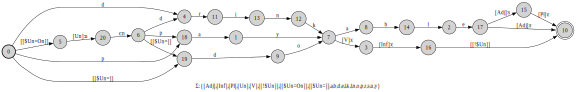

In [28]:
Lexicon.view()

## Controlling flag diacritic behavior

The functions `analyze` and `generate`, as well as, the `Paradigm` object accept two boolen arguments which determine how flag diacritics are handled in runtime and how they are displayed:

* `obey_flags` determines whether co-occurrence restrictions specified by flag diacritics are enforced (default: `True`)
* `print_flags` determines whether flags are printed (default: `False`)

While `undrink` is normally disallowed, we can generate it when we set `obey_flags` to `False`:

In [29]:
print(list(Lexicon.generate("[Un]drink[V][Inf]")))
print(list(Lexicon.generate("[Un]drink[V][Inf]",obey_flags=False)))

[]
['undrink']


The argument `print_flags` can be useful when debugging the behavior of flag diacritics. The output now displays the flag diacritics:

In [30]:
print(list(Lexicon.generate("[Un]drink[V][Inf]",obey_flags=False, print_flags=True)))

['[[$Un=On]]undrink[[!$Un]]']


## Eliminating flag diacritics

Given an FST with flag diacritics, foma can also calculate the equivalent transducer without the flags present. This is called flag elimination:

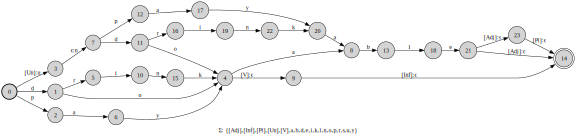

In [31]:
Lexicon.eliminate_flags()
Lexicon.view()

In [32]:
print(Paradigm(Lexicon, ".*"))

do         [Un][V][Inf]   undo          
do         [V][Inf]       do            
doable     [Adj]          doable        
doable     [Adj][Pl]      doables       
doable     [Un][Adj]      undoable      
doable     [Un][Adj][Pl]  undoables     
drink      [V][Inf]       drink         
drinkable  [Adj]          drinkable     
drinkable  [Adj][Pl]      drinkables    
drinkable  [Un][Adj]      undrinkable   
drinkable  [Un][Adj][Pl]  undrinkables  
pay        [V][Inf]       pay           
payable    [Adj]          payable       
payable    [Adj][Pl]      payables      
payable    [Un][Adj]      unpayable     
payable    [Un][Adj][Pl]  unpayables    

